In this kernel, we will apply a stroke classification with basic ml models. The outline of the project:
* Introduction
* Background and Motivation
* Packages & Libraries
* First look on the data
* Explatory Data Analysis
* Feature Engineering
* Encoding, Missing Value Imputation and Oversampling
* ML Models Building and Hyperparameter Tuning
* Model Evaluation

### Introduction
<img src="https://www.cdc.gov/stroke/images/Stroke-Medical-Illustration.jpg?_=77303?noicon">

### Background and Motivation

Background: A stroke, sometimes called a brain attack, occurs when something blocks blood supply to part of the brain or when a blood vessel in the brain bursts. Brain cells begin to die in minutes. A stroke is a medical emergency, and prompt treatment is crucial. A stroke can cause lasting brain damage, long-term disability, or even death. Early action can reduce brain damage and other complications.

Motivation: Our objective is to understand what are the reasons that cause stroke to people and see if we can succesfully detect stroke on the features from given data using ML techniques.

### Packages & Libraries

In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_curve, precision_recall_curve, auc, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")

### First Look on the Data

In [7]:
data = pd.read_csv("../input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv")
df = data.copy()
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [8]:
# drop unnecessary columns
df.drop(["id"], axis = 1, inplace = True)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [9]:
# data info: columns with data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [10]:
# bmi column seems it has null values. Let's check it out!
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

How many target variables of both "stroke" or "not stroke" classes on the dataset?

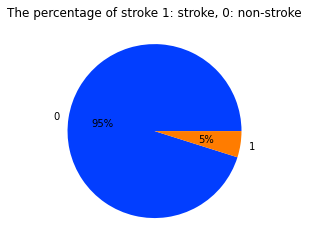

In [11]:
data = df["stroke"].value_counts()
labels = df["stroke"].value_counts().index

palette_color = sns.color_palette('bright')
plt.pie(data, labels=labels, colors=palette_color, autopct='%.0f%%')
plt.title("The percentage of stroke 1: stroke, 0: non-stroke");

#### Issues:
There is 201 null BMI values on the dataset. Additionally the data is imbalance therefore we need to solve these issues for better results.

### Explatory Data Analysis (EDA)

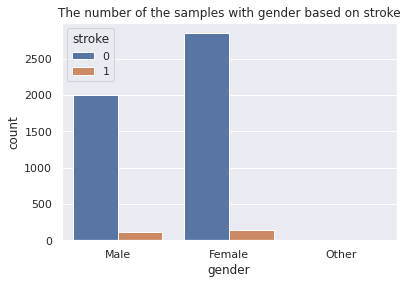

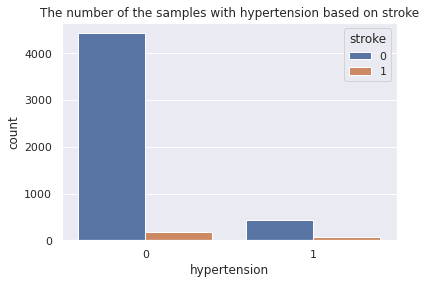

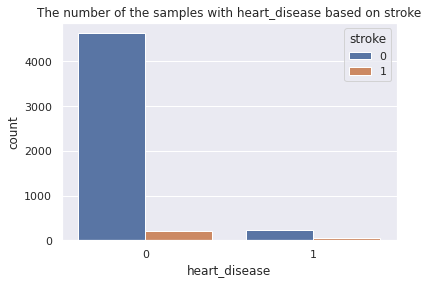

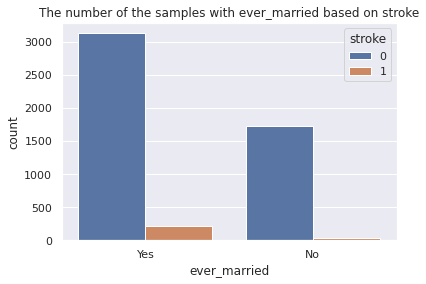

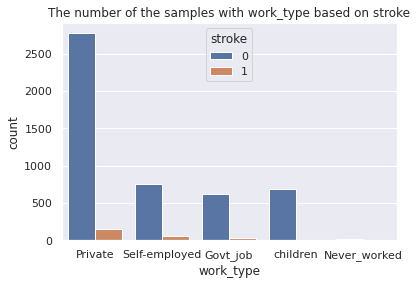

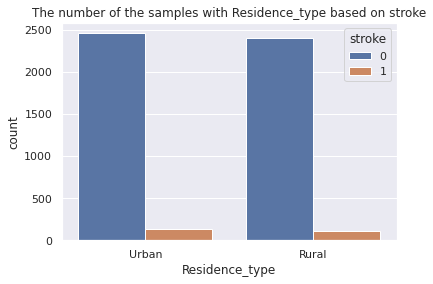

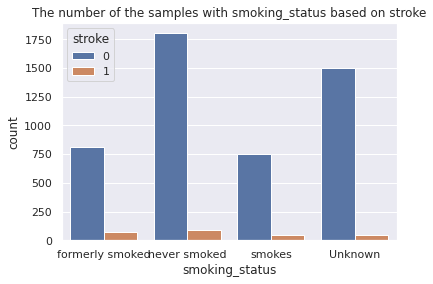

In [12]:
# a short look into the number of each categorical features grouped by stroke variable.
sns.set_theme(style = 'darkgrid')
for i in df.columns[:-1]:  # exclude stroke column
    if (df[i].dtype == 'object') or (df[i].dtype == 'int64'):
            sns.countplot(data = df, x = i, hue = 'stroke')
            plt.title('The number of the samples with {} based on stroke'.format(i))
            plt.show()

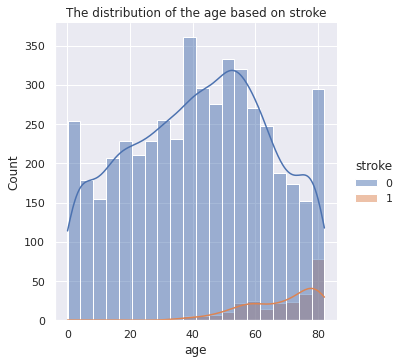

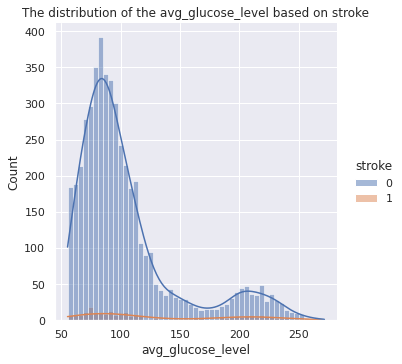

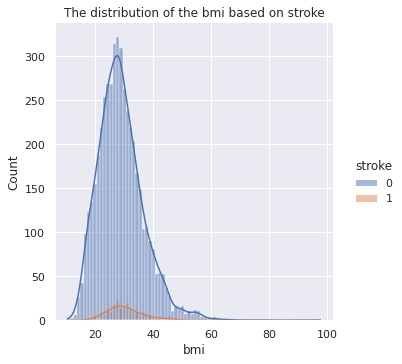

In [13]:
# a short look into numeric variables like bmi, avg_glucose_level and age
sns.set_theme(style = 'darkgrid')
for i in df.columns[:-1]: # exclude stroke column
    if df[i].dtype == 'float64':
            sns.displot(data = df, x = i, hue = 'stroke', kde = True)
            plt.title('The distribution of the {} based on stroke'.format(i))
            plt.show()

<AxesSubplot:>

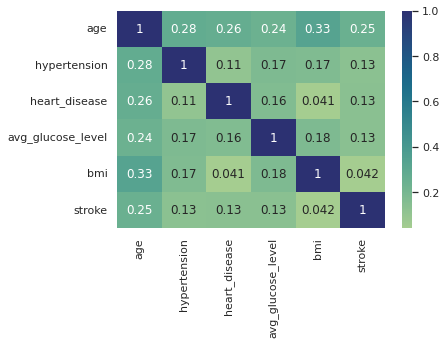

In [14]:
# Correlation heatmap
sns.heatmap(df.corr(), annot = True, cmap = 'crest')

### Feature Engineering
* Swarmplot, rugplot and kde plots to see the numeric variables' distributive differences between stroke or non-stroke conditions.
* Regression plots to see the relations between numeric variables like age, avg_glucose_level etc.
* Feature importance with Extra Tree Classifier

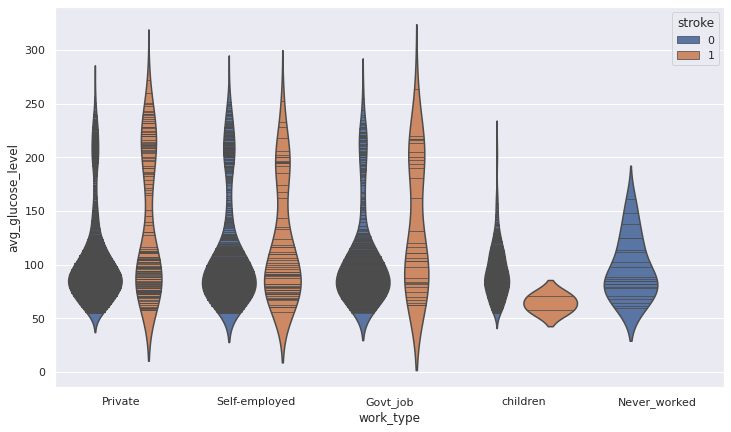

In [15]:
# Violin plot to visualize each numerical variables by stroke
plt.figure(figsize = (12, 7))
sns.violinplot(data = df, x = "work_type", y="avg_glucose_level", hue = 'stroke', inner = 'stick')
plt.show()

### Encoding, Missing Value Imputation and Oversampling

#### Encoding

In [16]:
# First we need to transform our columns to be encoded to numpy arrays
gender = df.iloc[:,0:1].values
ever_married = df.iloc[:,4].values  # reshaped 2d array for ordinal encoder
work_type = df.iloc[:,5:6].values
residence_type = df.iloc[:,6].values # reshaped 2d array for ordinal encoder
smoking_status = df.iloc[:,9:10].values

In [17]:
# Other variables
age = df[["age"]]
hypertension = df[["hypertension"]]
heart_disease = df[["heart_disease"]]
avg_glucose_level = df[["avg_glucose_level"]]
bmi = df[["bmi"]]
stroke = df[["stroke"]]

In [18]:
unique, counts = np.unique(ever_married, return_counts = True)
print(np.asarray((unique, counts)).T)

[['No' 1757]
 ['Yes' 3353]]


In [19]:
# Label Encoding for ever_married and residence_type columns which has two labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
ever_married = le.fit_transform(ever_married)
ever_married = pd.DataFrame(ever_married, columns = ["ever_married"])
print("Labels 0, 1:",le.classes_)
residence_type = le.fit_transform(residence_type)
residence_type = pd.DataFrame(residence_type, columns = ["residence_type"])
print("Labels 0, 1:",le.classes_)

Labels 0, 1: ['No' 'Yes']
Labels 0, 1: ['Rural' 'Urban']


In [20]:
# One Hot Encoding for gender, work_type and smoking status columns
ohe = OneHotEncoder(dtype = np.int64, sparse = False)
gender = ohe.fit_transform(gender)
gender = pd.DataFrame(gender, columns = ['female', 'male', 'other'])
print("Gender dummies respectively 0, 1, 2:", ohe.categories_)
work_type = ohe.fit_transform(work_type)
work_type = pd.DataFrame(work_type, columns = ['govt_job', 'never_worked', 'private', 'self-employed', 'children'])
print("Work type dummies respectively 0, 1, 2, 3, 4:", ohe.categories_)
smoking_status = ohe.fit_transform(smoking_status)
smoking_status = pd.DataFrame(smoking_status, columns = ['unknown', 'formerly_smoked', 'never_smoked', 'smokes'])
print("Smoking status dummies respectively 0, 1, 2, 3:", ohe.categories_)

Gender dummies respectively 0, 1, 2: [array(['Female', 'Male', 'Other'], dtype=object)]
Work type dummies respectively 0, 1, 2, 3, 4: [array(['Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children'],
      dtype=object)]
Smoking status dummies respectively 0, 1, 2, 3: [array(['Unknown', 'formerly smoked', 'never smoked', 'smokes'],
      dtype=object)]


In [21]:
frames = [gender, age, hypertension, heart_disease, ever_married, work_type, residence_type, avg_glucose_level, bmi, smoking_status, stroke]
df_en = pd.concat(frames, axis = 1)
df_en.head(3)

,female,male,other,age,hypertension,heart_disease,ever_married,govt_job,never_worked,private,self-employed,children,residence_type,avg_glucose_level,bmi,unknown,formerly_smoked,never_smoked,smokes,stroke
0,0,1,0,67.0,0,1,1,0,0,1,0,0,1,228.69,36.6,0,1,0,0,1
1,1,0,0,61.0,0,0,1,0,0,0,1,0,0,202.21,NaN,0,0,1,0,1
2,0,1,0,80.0,0,1,1,0,0,1,0,0,0,105.92,32.5,0,0,1,0,1


#### Missing Value Imputation

In [22]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'mean')
df_en = pd.DataFrame(imputer.fit_transform(df_en), columns = df_en.columns)
df_en.head()

,female,male,other,age,hypertension,heart_disease,ever_married,govt_job,never_worked,private,self-employed,children,residence_type,avg_glucose_level,bmi,unknown,formerly_smoked,never_smoked,smokes,stroke
0,0.0,1.0,0.0,67.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,228.69,36.600000,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,61.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,202.21,28.893237,0.0,0.0,1.0,0.0,1.0
2,0.0,1.0,0.0,80.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,105.92,32.500000,0.0,0.0,1.0,0.0,1.0
3,1.0,0.0,0.0,49.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,171.23,34.400000,0.0,0.0,0.0,1.0,1.0
4,1.0,0.0,0.0,79.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,174.12,24.000000,0.0,0.0,1.0,0.0,1.0


In [23]:
int_vars = ["female","male","other","age","hypertension","heart_disease","ever_married","govt_job","never_worked","private","self-employed", 
            "children", "residence_type","unknown","formerly_smoked","never_smoked","smokes"]

df1 = df_en[int_vars].astype(np.int64)
num_vars = ["avg_glucose_level","bmi"]
df2 = df_en[num_vars]
label = ["stroke"]
df3 = df_en[label]
df_en = pd.concat([df1, df2, df3], axis = 1)
df_en

,female,male,other,age,hypertension,heart_disease,ever_married,govt_job,never_worked,private,self-employed,children,residence_type,unknown,formerly_smoked,never_smoked,smokes,avg_glucose_level,bmi,stroke
0,0,1,0,67,0,1,1,0,0,1,0,0,1,0,1,0,0,228.69,36.600000,1.0
1,1,0,0,61,0,0,1,0,0,0,1,0,0,0,0,1,0,202.21,28.893237,1.0
2,0,1,0,80,0,1,1,0,0,1,0,0,0,0,0,1,0,105.92,32.500000,1.0
3,1,0,0,49,0,0,1,0,0,1,0,0,1,0,0,0,1,171.23,34.400000,1.0
4,1,0,0,79,1,0,1,0,0,0,1,0,0,0,0,1,0,174.12,24.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,1,0,0,80,1,0,1,0,0,1,0,0,1,0,0,1,0,83.75,28.893237,0.0
5106,1,0,0,81,0,0,1,0,0,0,1,0,1,0,0,1,0,125.20,40.000000,0.0
5107,1,0,0,35,0,0,1,0,0,0,1,0,0,0,0,1,0,82.99,30.600000,0.0
5108,0,1,0,51,0,0,1,0,0,1,0,0,0,0,1,0,0,166.29,25.600000,0.0


In [24]:
df_en.isnull().sum()

female               0
male                 0
other                0
age                  0
hypertension         0
heart_disease        0
ever_married         0
govt_job             0
never_worked         0
private              0
self-employed        0
children             0
residence_type       0
unknown              0
formerly_smoked      0
never_smoked         0
smokes               0
avg_glucose_level    0
bmi                  0
stroke               0
dtype: int64

#### Oversampling with Synthetic Minority Oversampling Technique (SMOTE)

In [27]:
from imblearn.over_sampling import SMOTE
X, y = df_en.iloc[:, 0:-1], df_en.iloc[:, -1:]

print("Before Oversampling, the counts of label 1: ", y.value_counts()[1])
print("Before Oversampling, the counts of label 0: ", y.value_counts()[0])

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

print("After Oversampling, the counts of label 1: ", y.value_counts()[1])
print("After Oversampling, the counts of label 0: ", y.value_counts()[0])

Before Oversampling, the counts of label 1:  249
Before Oversampling, the counts of label 0:  4861
After Oversampling, the counts of label 1:  4861
After Oversampling, the counts of label 0:  4861


#### Visualization After Oversampling

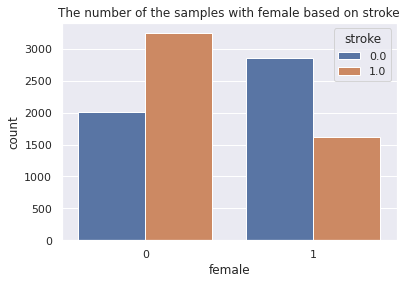

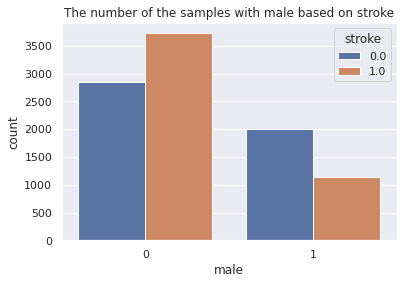

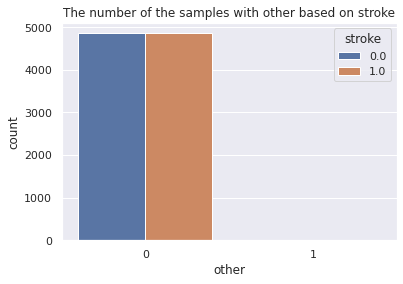

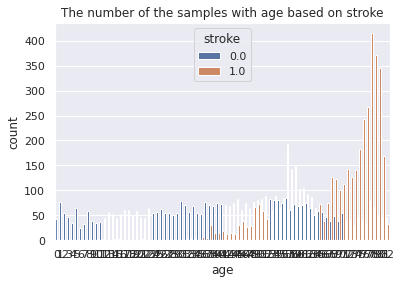

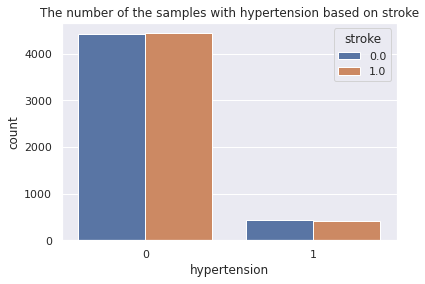

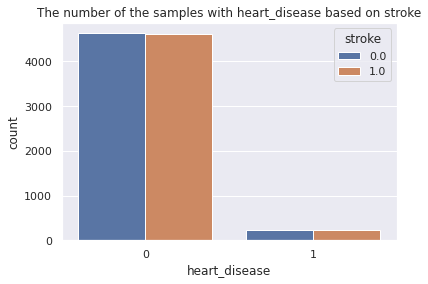

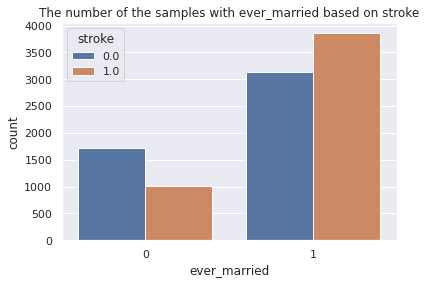

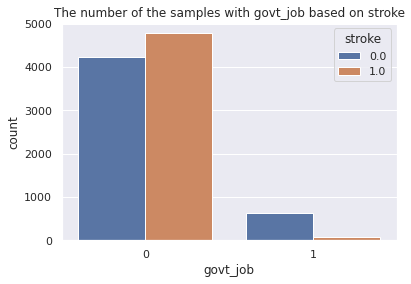

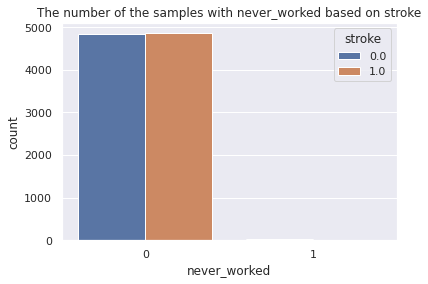

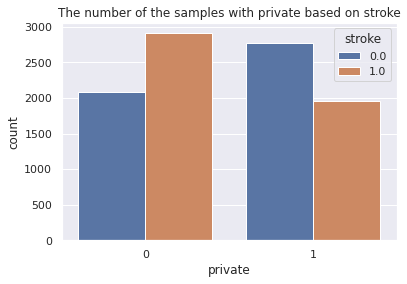

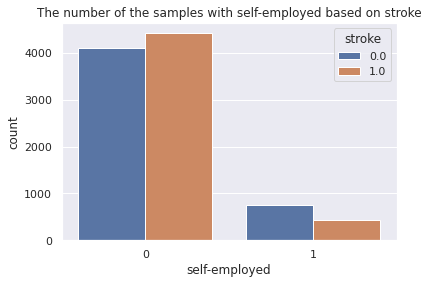

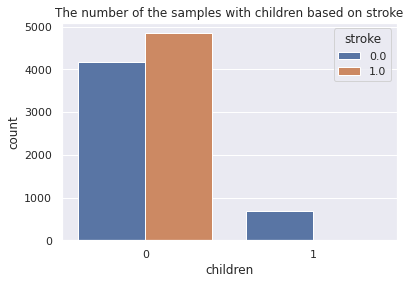

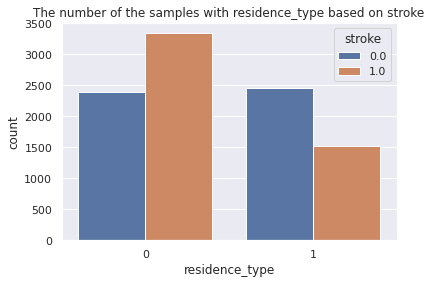

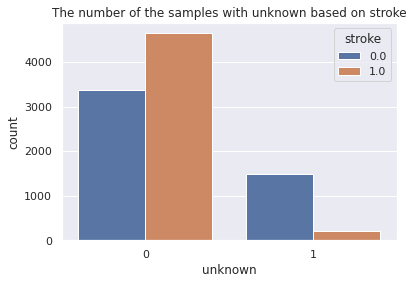

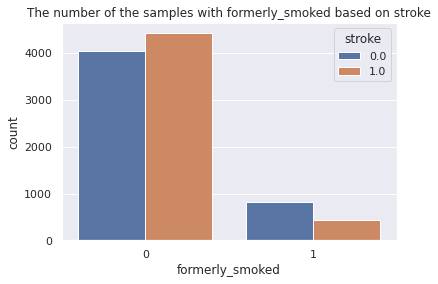

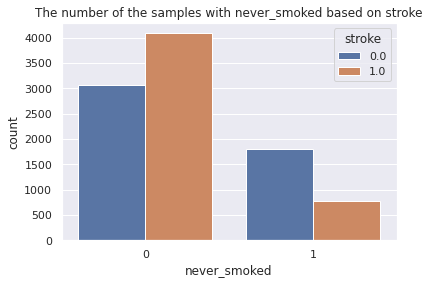

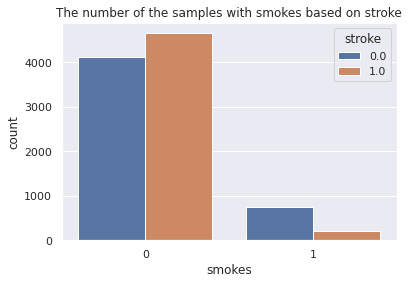

In [168]:
# visualization after SMOTE
df_as = pd.concat([X, y], axis = 1)

# a short look into the number of each categorical features grouped by stroke variable.
sns.set_theme(style = 'darkgrid')
for i in df_as.columns[:-1]:  # exclude stroke column
    if (df_as[i].dtype == 'object') or (df_as[i].dtype == 'int64'):
            sns.countplot(data = df_as, x = i, hue = 'stroke')
            plt.title('The number of the samples with {} based on stroke'.format(i))
            plt.show()

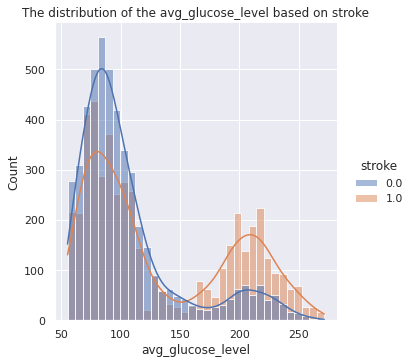

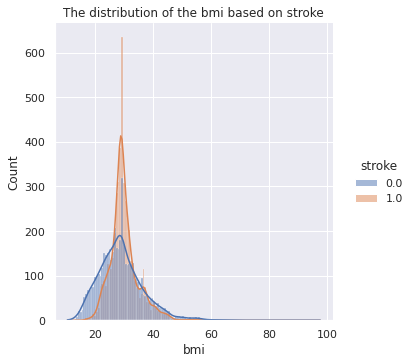

In [171]:
sns.set_theme(style = 'darkgrid')
for i in df_as.columns[:-1]: # exclude stroke column
    if df_as[i].dtype == 'float64':
            sns.displot(data = df_as, x = i, hue = 'stroke', kde = True)
            plt.title('The distribution of the {} based on stroke'.format(i))
            plt.show()

#### Splitting Data and Feature Scaling

In [30]:
# Splitting data to validation and training
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Scaling features between -1 and 1
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

### ML Models & Hyperparameter Tuning

#### Model Preparation

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model:  Logistic Regression
Validation Accuracy:  0.9398457583547558
Training Accuracy:  0.9501092966439502


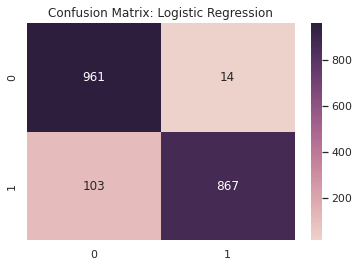

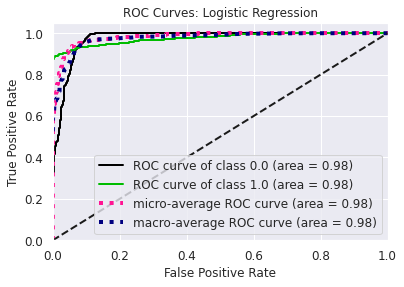

Model:  Decision Tree Classifier
Validation Accuracy:  0.9408740359897172
Training Accuracy:  1.0


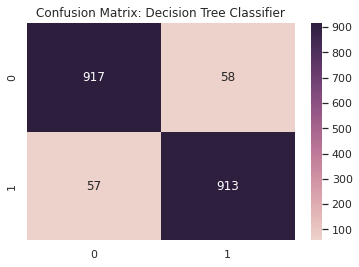

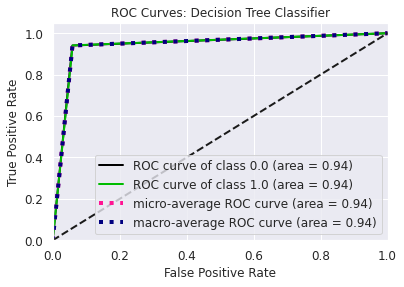

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Model:  Random Forest
Validation Accuracy:  0.9665809768637532
Training Accuracy:  1.0


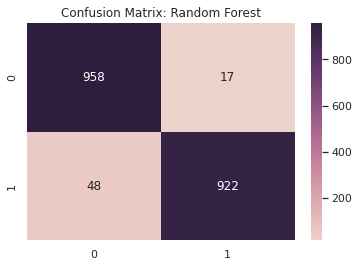

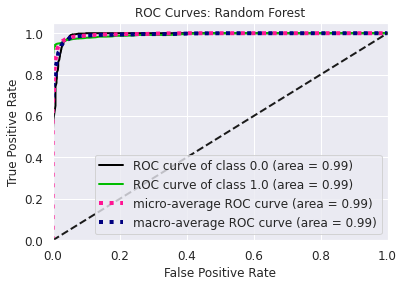

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model:  Linear Discriminant Analyzer
Validation Accuracy:  0.9285347043701799
Training Accuracy:  0.9346791822039346


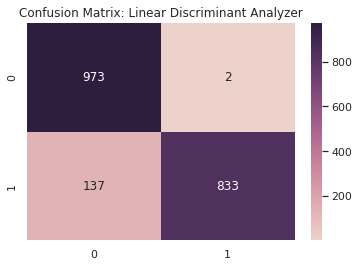

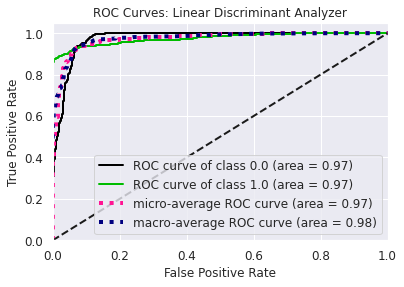

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model:  Ada Boost
Validation Accuracy:  0.9300771208226221
Training Accuracy:  0.9432943294329433


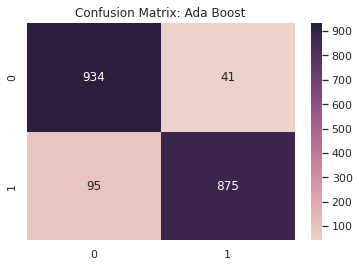

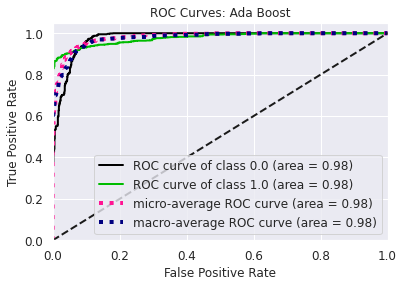

/opt/conda/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model:  KNN
Validation Accuracy:  0.9593830334190231
Training Accuracy:  0.9688826025459689


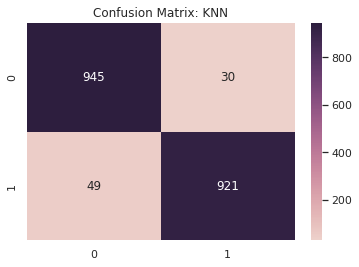

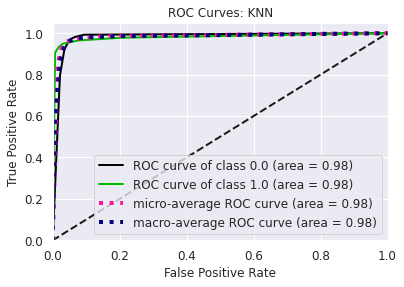

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model:  Support Vector Classifier
Validation Accuracy:  0.9434447300771208
Training Accuracy:  0.9569242638549569


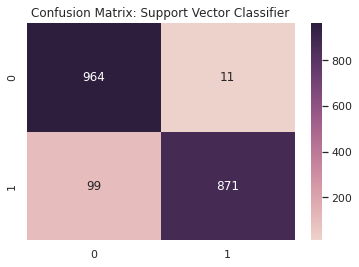

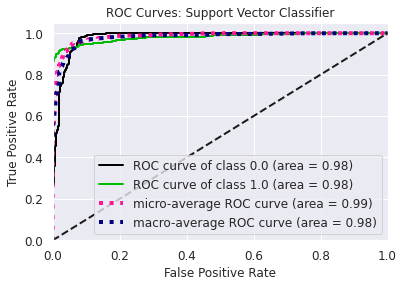

Model:  XG Boost
Validation Accuracy:  0.9629820051413882
Training Accuracy:  0.9983284042689984


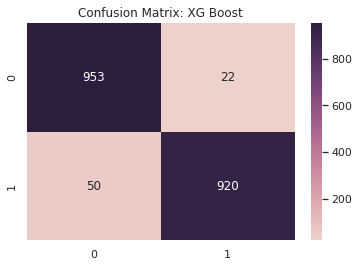

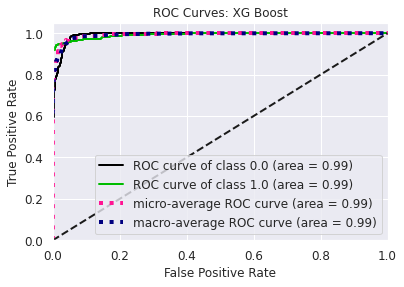

Model:  Cat Boost
Validation Accuracy:  0.9629820051413882
Training Accuracy:  0.9898418413269898


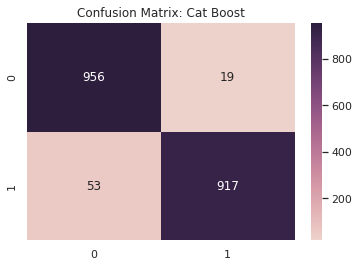

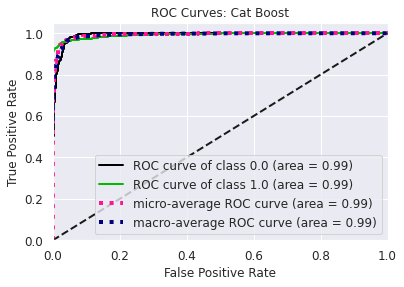

In [130]:
models = [('Logistic Regression', LogisticRegression()),
          ('Decision Tree Classifier', DecisionTreeClassifier()),
          ('Random Forest', RandomForestClassifier()),
          ('Linear Discriminant Analyzer', LinearDiscriminantAnalysis()),
          ('Ada Boost', AdaBoostClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('Support Vector Classifier', SVC(probability = True)),
          ('XG Boost', XGBClassifier()),
          ('Cat Boost', CatBoostClassifier(logging_level = 'Silent'))]

models_score = []
for name, model in models:
    model = model
    model.fit(x_train, y_train)
    model.predict(x_test)
    models_score.append([name, accuracy_score(y_test, model.predict(x_test))])
    
    print("Model: ",name)
    print('Validation Accuracy: ', accuracy_score(y_test, model.predict(x_test)))
    print('Training Accuracy: ', accuracy_score(y_train, model.predict(x_train)))
    
    plt.figure()
    cf_matrix = confusion_matrix(y_test, model.predict(x_test))
    plt.title('Confusion Matrix: {}'.format(name))
    sns.heatmap(cf_matrix, annot = True, fmt = 'g', cmap = sns.cubehelix_palette(as_cmap=True))
    plt.show()
    
    import scikitplot as skplt

    skplt.metrics.plot_roc(y_test, model.predict_proba(x_test))
    plt.title('ROC Curves: {}'.format(name))
    plt.show()

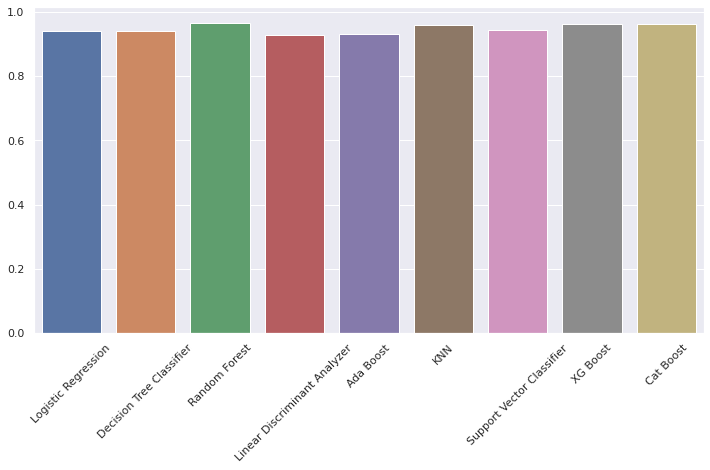

In [131]:
# Barplot to show the test accuracy scores of each algorithms
plt.figure(figsize = (12, 6))
sns.barplot(x = np.array(models_score)[:, 0], y=np.array(models_score)[:, 1].astype('float64'))
plt.xticks(rotation = 45);

#### Hyperparameter Tuning

In [172]:
# Models with hyperparameters to be tuned
grid_models = [(LogisticRegression(),[{'C' : [0.3, 0.7, 1], 'random_state' : [42]}]),
               (DecisionTreeClassifier(),[{'criterion' : ['gini','entropy'], 'random_state' : [42]}]),
               (RandomForestClassifier(),[{'n_estimators' : [100, 200, 300], 'criterion' : ['gini','entropy'], 'random_state' : [42]}]),
               (LinearDiscriminantAnalysis(),[{'solver' : ['svd', 'lsqr', 'eigen']}]),
               (AdaBoostClassifier(),[{'n_estimators' : [50, 100, 150], 'random_state' : [42]}]),
               (KNeighborsClassifier(),[{'n_neighbors' : [4, 6, 8, 10], 'metric' : ['euclidean', 'manhattan', 'chebyshev','minkowski']}]),
               (SVC(),[{'C' : [0.3, 0.7, 1], 'kernel' : ['rbf','linear','polynomial'], 'random_state' : [42]}]),
               (XGBClassifier(),[{'max_depth' : [3, 5, 7], 'min_child_weight' : [1, 3, 5]}]),
               (CatBoostClassifier(),[{'n_estimators' : [100, 200, 300], 'max_depth' : [3,5,7]}])]

In [156]:
for model, param_grid  in grid_models:
    cv = GridSearchCV(estimator = model, param_grid = param_grid, scoring = 'accuracy', cv = 5)
    cv.fit(x_train, y_train)
    best_accuracy = cv.best_score_
    best_params = cv.best_params_
    print('{}: \nBest Accuracy: {:.2f}%'.format(model, best_accuracy*100))
    print('Best Parameters: ',best_params)
    print('******************************')

LogisticRegression(): 
Best Accuracy: 94.91%
Best Parameters:  {'C': 0.3, 'random_state': 42}
******************************
DecisionTreeClassifier(): 
Best Accuracy: 94.42%
Best Parameters:  {'criterion': 'entropy', 'random_state': 42}
******************************
RandomForestClassifier(): 
Best Accuracy: 96.95%
Best Parameters:  {'criterion': 'gini', 'n_estimators': 100, 'random_state': 42}
******************************
LinearDiscriminantAnalysis(): 
Best Accuracy: 93.37%
Best Parameters:  {'solver': 'svd'}
******************************
AdaBoostClassifier(): 
Best Accuracy: 94.51%
Best Parameters:  {'n_estimators': 150, 'random_state': 42}
******************************
KNeighborsClassifier(): 
Best Accuracy: 96.09%
Best Parameters:  {'metric': 'manhattan', 'n_neighbors': 4}
******************************
SVC(): 
Best Accuracy: 95.17%
Best Parameters:  {'C': 1, 'kernel': 'rbf', 'random_state': 42}
******************************
XGBClassifier(base_score=None, booster=None, callbac

Looking at the results we can easily determine that the Random Forest, XGBoost and Cat Boost algorithms give the best scores so we had better tune these algorithms for better test scores.

#### Determined Models with Tuned Parameters

Model:  Random Forest
Validation Accuracy:  0.9691516709511568
Training Accuracy:  1.0


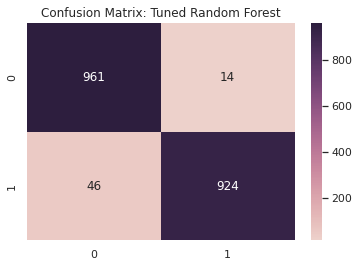

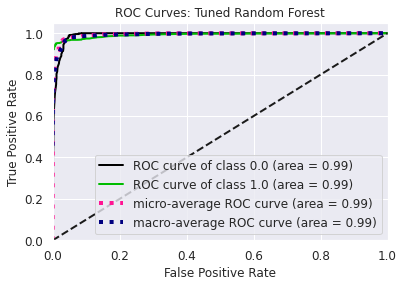

Feature: 0, Score: 0.04797
Feature: 1, Score: 0.04543
Feature: 2, Score: 0.00003
Feature: 3, Score: 0.27244
Feature: 4, Score: 0.00887
Feature: 5, Score: 0.00816
Feature: 6, Score: 0.01521
Feature: 7, Score: 0.04118
Feature: 8, Score: 0.00047
Feature: 9, Score: 0.03718
Feature: 10, Score: 0.03694
Feature: 11, Score: 0.01801
Feature: 12, Score: 0.02402
Feature: 13, Score: 0.07076
Feature: 14, Score: 0.05136
Feature: 15, Score: 0.06899
Feature: 16, Score: 0.04492
Feature: 17, Score: 0.12143
Feature: 18, Score: 0.08662


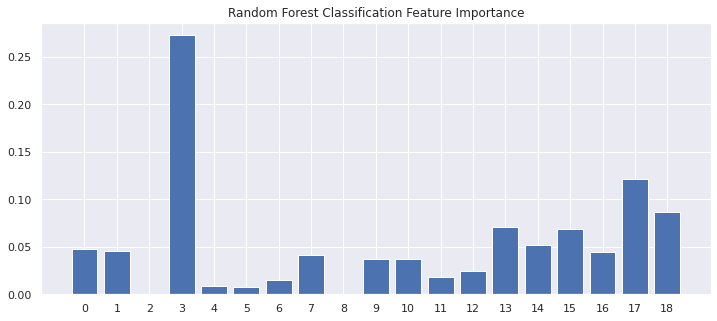


#######################################################
#######################################################

Model:  XG Boost
Validation Accuracy:  0.9624678663239075
Training Accuracy:  1.0


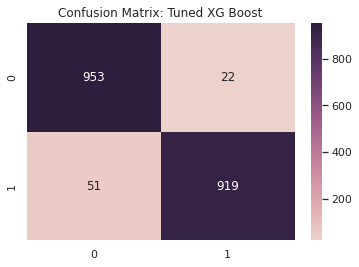

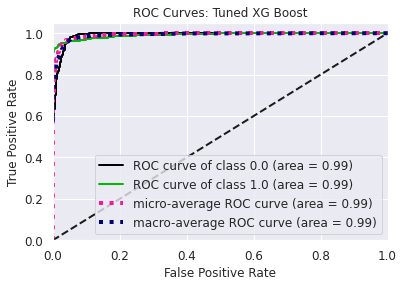

Feature: 0, Score: 0.08194
Feature: 1, Score: 0.09241
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.06966
Feature: 4, Score: 0.00639
Feature: 5, Score: 0.01148
Feature: 6, Score: 0.02641
Feature: 7, Score: 0.15357
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.07111
Feature: 10, Score: 0.07546
Feature: 11, Score: 0.01534
Feature: 12, Score: 0.01353
Feature: 13, Score: 0.09652
Feature: 14, Score: 0.08678
Feature: 15, Score: 0.05333
Feature: 16, Score: 0.12795
Feature: 17, Score: 0.01051
Feature: 18, Score: 0.00760


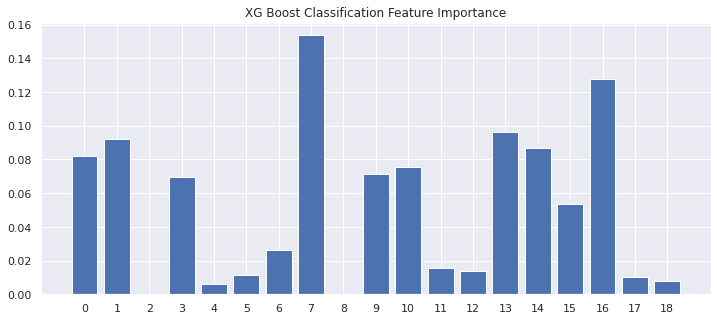


#######################################################
#######################################################

Model:  Cat Boost
Validation Accuracy:  0.9660668380462725
Training Accuracy:  0.9933136170759933


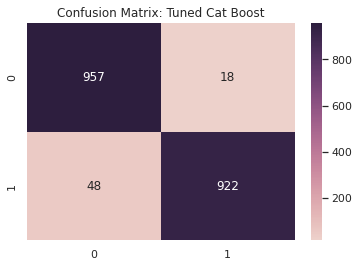

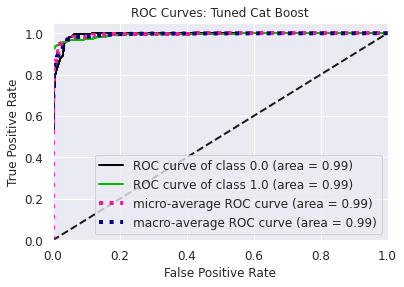

Feature: 0, Score: 7.83090
Feature: 1, Score: 7.02398
Feature: 2, Score: 0.00000
Feature: 3, Score: 13.24840
Feature: 4, Score: 0.32010
Feature: 5, Score: 0.42039
Feature: 6, Score: 1.07278
Feature: 7, Score: 4.07312
Feature: 8, Score: 0.00000
Feature: 9, Score: 9.08039
Feature: 10, Score: 6.01280
Feature: 11, Score: 0.00000
Feature: 12, Score: 1.32501
Feature: 13, Score: 10.62165
Feature: 14, Score: 8.35441
Feature: 15, Score: 12.28453
Feature: 16, Score: 6.48412
Feature: 17, Score: 6.89446
Feature: 18, Score: 4.95298


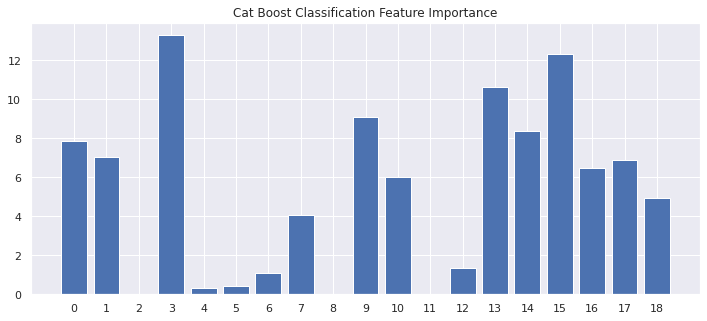


#######################################################
#######################################################



In [193]:
models = [('Random Forest', RandomForestClassifier(criterion = 'gini', n_estimators = 100, random_state = 42)),
          ('XG Boost', XGBClassifier(max_depth = 7, min_child_weight = 1)),
          ('Cat Boost', CatBoostClassifier(max_depth = 7, n_estimators = 300, logging_level = 'Silent'))]

models_score = []
for name, model in models:
    model = model
    model.fit(x_train, y_train)
    model.predict(x_test)
    models_score.append([name, accuracy_score(y_test, model.predict(x_test))])
    
    print("Model: ",name)
    print('Validation Accuracy: ', accuracy_score(y_test, model.predict(x_test)))
    print('Training Accuracy: ', accuracy_score(y_train, model.predict(x_train)))
    
    plt.figure()
    cf_matrix = confusion_matrix(y_test, model.predict(x_test))
    plt.title('Confusion Matrix: Tuned {}'.format(name))
    sns.heatmap(cf_matrix, annot = True, fmt = 'g', cmap = sns.cubehelix_palette(as_cmap=True))
    plt.show()
    
    import scikitplot as skplt

    skplt.metrics.plot_roc(y_test, model.predict_proba(x_test))
    plt.title('ROC Curves: Tuned {}'.format(name))
    plt.show()
    
    importance = model.feature_importances_
    # summarize feature importance
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    # plot feature importance
    plt.figure(figsize = (12, 5))
    plt.bar([x for x in range(len(importance))], importance)
    plt.title("{} Classification Feature Importance".format(name))
    plt.xticks(range(0, 19))
    plt.show()
    print('')
    print('#######################################################')
    print('#######################################################')
    print('')